# Física Nuclear y de Partículas
## Ejercicio voluntario, análisis de datos simulados.
## desintegraciones del tau

*autores: Mauricio A. Ponce Távara*

*versión: Diciembre 2022*

## Introducción

El fichero *taus_45GeV.csv* contiene una muestra de eventos con desintegraciones $\tau$ de 45 GeV de Energía.

Cada evento contiene la lista de las párticulas detectadas por un experimento ideal, con su la posicion (en mm), el momento (en MeV), la energía (en MeV). 

Los taus se producen en el origen y el experimento mide con exactitud la posición, el momento y energía de los $\gamma, \, e^\pm, \, \mu^\pm, \pi^\pm$ que alcanzan un detector ideal que es una esfera de 5 cm centrada en el origen.

Los datos están organizados en una tabla. Cada fila corresponde a una partícula y cada columna corresponde a una variable, por ejemplo, la energía de las partículas viene dada en la columna con la etiqueta *E*. Una de las columnas es el número del evento (*event*). Para seleccionar las partículas de un evento, seleccionamos las filas que tiene el mismo número de evento en la columna *event*.

En este *notebook* diponéis de código adicional que os facilitará los cálculos y ejemplos de cómo usarlo. Pero podéis utilizar la herramienta que prefiráis.

El trabajo se puede realizar individual o en grupos de no más de 4 personas, y lo podéis entragar en el formato que prefiráis en la tarea correspondiente del aula virtual.


## Ejercicio

Con la presente muestra de datos, desarrolla el siguuiente análisis y responde a alguna de las cuestiones:

  * ¿Cuántos $\tau^-$ y $\tau^+$ hay en la muestra? 

  * Estima con esta muestra la fracción de desintegración en los canales principales del $\tau$.

    - ¿Cuáles son los canales detectados y su fracción de producción? 
    
    - Asocia e identidica los canales detectados con los canales de desintegración del $\tau$ (revisa para ello las páginas de PDG del $\tau$ y $\pi^0, \pi^\pm$.

  * Compara la distribución de la energía del $e^\pm$ y $\mu^\pm$ en los eventos con uno solo de esos leptones. 
  
    - Comparala ahora esas distribuciones con la del $\pi^\pm$ en los eventos donde solo se emite un $\pi^\pm$. 

  * Calcula la distancia de vuelo del $\tau$ reconstruyendo su vértice de desintegración. Estima el tiempo de vida media del $\tau$.

      - Verifica que la masa invariante de los eventos con dos $\gamma$ corresponde a la masa de un $\pi^0$

      - Considera que las partículas no están sometidas a un campo magnético y que sus trayectorias son línea rectas.

      - Utilizara los canales con 1 $\pi^0$ o con 3 piones cargados para obtener la distribución de la distancia de vuelo.

      - En dichos canales ¿Puedes reconstruir el momento del $\nu_\tau$ que escapa indetectado?

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import operator as op
from collections import Counter

In [2]:
## NOTA: ¡Modifica la variable *datadir* para que apunte al directorio de tu ordenador donde has guardado el fichero de datos!
datadir  = "C:/Users/ma666/Downloads/US/4ºcurso/FNP/Análisis de datos Tau"
datafile = "/taus_45GeV.csv"
data     = pd.read_csv(datadir + datafile)

In [3]:
data

,event,particleName,x,y,z,px,py,pz,E
0,0,gamma,-46.665398,14.573922,10.485294,-4108.790087,1283.199766,923.202142,4402.392510
1,0,gamma,-46.554595,14.452292,11.126588,-21958.518406,6816.712327,5248.202276,23583.632558
2,0,pi-,-46.000031,16.477644,10.605868,-9160.779055,3281.545421,2112.151205,9958.367124
3,1,mu+,-13.628892,-3.544433,-47.975935,-5514.644806,-1398.599609,-19290.163449,20111.910844
4,2,gamma,47.077349,-14.529804,8.521030,1265.384717,-389.821084,228.823194,1343.696027
...,...,...,...,...,...,...,...,...,...
65334,29997,pi+,17.005018,-24.666768,40.029738,2118.552388,-3075.607023,4991.097398,6235.235026
65335,29998,gamma,34.489961,6.631228,35.587490,3224.056973,623.609560,3321.844324,4670.982976
65336,29998,gamma,35.298867,6.010952,34.897829,4330.902982,740.133289,4270.943351,6127.436253
65337,29998,pi+,33.336556,3.488380,37.101284,16128.464281,1671.441608,17957.905008,24195.596897


funciona hablándole por columnas. Así se opera con data en Nuclear.

## Code


In [4]:
from collections import namedtuple
Particle = namedtuple('Particle', ('x', 'p', 'E', "name"))
def event_particles(data, event_number):
    """
    return the list of particles an event
    
    Inputs
        data          : DataFrame, 
        event_number  : int, number of event
    
    Return
        particles : a list of particles
        each particle has
            x    : np.array, 3D vector, the detected position (mm)
            p    : np.array, 3D vector, the detected momemtum  (MeV)
            E    : float, detected energy (MeV)
            name : string, name of the particle, i.e. "e+"
    """
    dpars = data[data.event == event_number] ## get the particles of the same event
    npars = len(dpars) ## number of particles in the event
    pars  = [Particle(np.array((dpars.x.values[i] , dpars.y.values[i] , dpars.z.values[i])), 
                      np.array((dpars.px.values[i], dpars.py.values[i], dpars.pz.values[i])),
                      dpars.E.values[i], dpars.particleName.values[i]) for i in range(npars)]
    return pars


In [5]:
def event_channel(data, event_number):
    """ return the detected channel, a string with the list of the different types of particles and how many times they are in the the event
    i.e: '2 gamma, 1 pi-', indicates that in the event with number *event_number* has been detected 2 gammas and 1 pi-

    Inputs:    
        data          : DataFrame, 
        event_number  : int, number of event

    Returns:
        str, string with the count of the different type of particle in the event
    """
    edata = data[data.event == event_number] ## get the particles of the event
    pars  = list(edata.particleName) ## get the names of the particles 
    pars.sort()
    spars = str([str(pars.count(name))+' '+name for name in set(pars)])
    spars = spars.replace("'", "")
    spars = spars.replace("[", "")
    spars = spars.replace("]", "")
    return spars


In [6]:
def event_charge(data, event_number):
    """ returns the event charge (in e units)
    
    Inputs:
        data         : DataFrame
        event_number : int, event number
    
    Returns
        charge       : int, the charge of the event
    """
    edata  = data[data.event == event_number] # get the particle of the event
    names  = str(list(edata.particleName)) ## get the event of the particles
    nplus  = names.count("+") ## count how many are '+'
    nminus = names.count("-") ## count how many are '-'
    charge = nplus - nminus
    return charge

In [7]:
import scipy.linalg as la
def intersection_of_straight_lines(x1, v1, x2, v2):
    """ compute the instersection point of two straight lines

    Inputs:
        x1: tuple or np.array, reference point of line 1
        v1: tuple or np.array, direction vector of line 1
        x1: tuple or np.array, reference point of line 1
        v1: tuple or np.array, direction vector of line 1

    Returns:
        x: np.array, the closest point of line 1 to the intersection
                     the intersection point if both lines really intersect

    Algorithm:
        Intersection of two straight lines:
            x1(t) = x1 + t1 * v1
            x2(t) = x2 + t2 * v2,
        where x1 is a point in the line 1 and v1 is the direction vector (i.e momentum), and t1 is the running parameter.
        x1, v2, t2 the same for line 2. 
        
        condition: x1(t) = x2(t) => x2- x1 = t1 * v1 - t2 * v2
        solve the equations and estimate the two scalars: t1 and t2 
    """


    x1 = np.array(x1)
    x2 = np.array(x2)
    v1 = np.array(v1)
    v2 = np.array(v2)

    bb = x2 - x1
    ndim = len(bb)
    aa = np.zeros((ndim, 2))
    aa[:, 0] =  v1
    aa[:, 1] = -v2

    tt = la.lstsq(aa, bb)[0]
    x1i = x1 + tt[0] * v1
    return x1i


## Ejemplos

### Obtener el número de eventos

In [8]:
## Number of events in the data
nevents = len(np.unique(data.event.values))
print(" number of events {:d}".format(nevents))

 number of events 30000


### Obtener las partículas de un evento

In [ ]:
## get the particles of the event number 0
ievent    = 0
particles = data[data.event == ievent]
particles

,event,particleName,x,y,z,px,py,pz,E
0,0,gamma,-46.665398,14.573922,10.485294,-4108.790087,1283.199766,923.202142,4402.392510
1,0,gamma,-46.554595,14.452292,11.126588,-21958.518406,6816.712327,5248.202276,23583.632558
2,0,pi-,-46.000031,16.477644,10.605868,-9160.779055,3281.545421,2112.151205,9958.367124


"""Cambiar en ievent el evento que quiera"""

In [ ]:
## alternative way to get the particles of the event number 0
ievents   = 0
particles = event_particles(data, ievent)
for i, particle in enumerate(particles):
    print(" particle: index = ", i, 
           ", position x = "   , particle.x,
           ", momentum p = "   , particle.p,
           ", Energy E = "     , particle.E,
           ", type = "          , particle.name)

 particle: index =  0 , position x =  [-46.66539837  14.57392213  10.48529394] , momentum p =  [-4108.79008681  1283.19976634   923.20214219] , Energy E =  4402.39251011878 , type =  gamma
 particle: index =  1 , position x =  [-46.55459489  14.45229176  11.12658788] , momentum p =  [-21958.51840571   6816.71232738   5248.20227557] , Energy E =  23583.63255848045 , type =  gamma
 particle: index =  2 , position x =  [-46.00003078  16.47764361  10.60586768] , momentum p =  [-9160.77905515  3281.54542054  2112.15120504] , Energy E =  9958.367123688897 , type =  pi-


### Obtener la lista con el número de los distintos tipos de partículas detectadas en un evento

In [ ]:
## detected channel of the event 0
ievent  = 2457
channel = event_channel(data, ievent)
print("Detected channel (particles) of event {:d} = {:s}".format(ievent, channel))

Detected channel (particles) of event 2457 = 1 e+


### Obtener la carga de un evento

In [ ]:
# charge of the event 0
ievent = 0
charge = event_charge(data, ievent)
print("Total electric charge of the event {:d} = {:d} (e)".format(ievent, charge))

Total electric charge of the event 0 = -1 (e)


### Obtener la distribución de energía de los muones en eventos con un solo muón.

Total number of events with 1 mu- = 2816
Average muon energy E = 16328.989 MeV


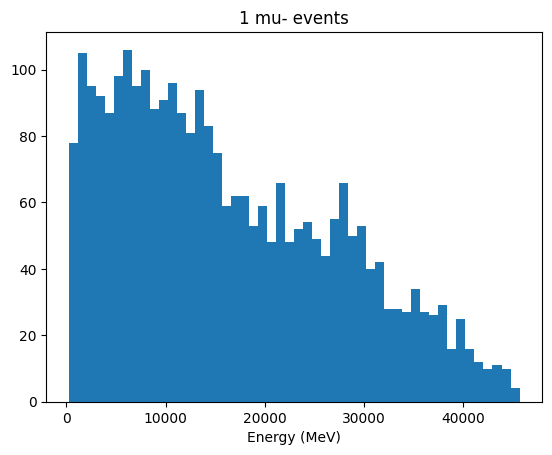

In [ ]:

## Energy distribution of the events with 1 muon
energies = []
for ievent in range(nevents):
    channel = event_channel(data, ievent) # get the detected channel
    if (channel == "1 mu-"):  # select only events with only 1 muon
        particles   = event_particles(data, ievent) # get the particles of the event
        muons       = [particle for particle in particles if particle.name == "mu-"] # select only the muons (there is only 1!)
        muon        = muons[0] # take the 1 muon from the list of muons
        muon_energy = muon.E
        energies.append(muon_energy)

plt.hist(energies, bins = 50)
plt.xlabel("Energy (MeV)")
plt.title("1 mu- events")
print("Total number of events with 1 mu- = {:d}".format(len(energies)))
print("Average muon energy E = {:4.3f} MeV".format(np.mean(energies)))

Podemos hacer un ajuste usando el paquete zfit.

### Obtener la masa invariante de dos gammas en un evento

In [ ]:
## We compute the invariant mass of the gammas of the event 0
ievent    = np.random.randint(2999)
particles = event_particles(data, ievent)
gammas    = [particle for particle in particles if particle.name == "gamma"]
gamma1    = gammas[0]
gamma2    = gammas[1]
energy_sum   = gamma1.E + gamma2.E
momentum_sum = gamma1.p + gamma2.p
inv_mass     = np.sqrt( (energy_sum)**2 - sum(momentum_sum * momentum_sum))
print("Event {:d}, invariant mass of the 2 gammas = {:4.3f} MeV".format(ievent, inv_mass))
# Notice that 135 is the mass of the pi0! 
# Look for the lifetime and decays of the pi0 in the PDG

Event 2429, invariant mass of the 2 gammas = 134.977 MeV


### Obtener el punto de intersección, el vértice de producción, de dos gammas que provienen de un $\pi^0$

In [ ]:
## We compute the veretex of the two gammas generated from the pi0 decay of the event 0
ievent    = 779
particles = event_particles(data, ievent) 
gammas    = [particle for particle in particles if particle.name == "gamma"]
gamma1    = gammas[0]
gamma2    = gammas[1]
gamma1_x  = gamma1.x
gamma1_p  = gamma1.p
gamma2_x  = gamma2.x
gamma2_p  = gamma2.p
vertex    = intersection_of_straight_lines(gamma1_x, gamma1_p, gamma2_x, gamma2_p)
print("Vertex of the two gammas (in mm) = " , vertex)

IndexError: list index out of range

### Calcular la distancia de vuelo del $\tau$ en un evento con un $\pi^0$

In [ ]:
## In the event 0, the 2 gammas come from the p0 decay, which decay inmediately and which is a decay product of the tau. 
## Therefore, the vertex of the 2 gammas, is the vertex of the tau decay
## As the taus are produced at origin (0, 0, 0), we compute the fliht distance of the tau of the event 0
ievent    = 779
particles = event_particles(data, ievent) 
gammas    = [particle for particle in particles if particle.name == "gamma"]
gamma1    = gammas[0]
gamma2    = gammas[1]
vertex    = intersection_of_straight_lines(gamma1.x, gamma1.p, gamma2.x, gamma2.p)
distance  = np.sqrt(sum(vertex * vertex))
print("Event {:d}, tau flight distance = {:4.3f} mm".format(ievent, distance))

IndexError: list index out of range

## Mau
## 1
3000 events indicate a sample of 3000. In order to differentiate between $\tau^-$ and $\tau^+$ we can make use of  the conservation of charge. Because the charge is conserved in every event, any $\tau^-$'s decay channel must have a charge of -(e); and the same principle can be applied for the $\tau^+$. 

In [ ]:
#Mau
##Código para contar cuántos taus y antitaus hay en la muestra.
evs=np.arange(0,nevents,1)
chargelist=[]
for k in evs:
    ievent = k
    charge = event_charge(data, ievent)
    chargelist.append(charge)
    numt=chargelist.count(-1)
    numant=chargelist.count(1)
print('Tenemos {} canales con carga -e (corresponden a \u03C4^-) y {} canales con carga +e (\u03C4^+)' .format(numt,numant))



## 2 Estima con la fracción de desintegración en los canales principales del $\tau$
Según el PDG los canales principales (considero los 6 de mayor fracción de desintegración) del $\tau^-$ son:
 * hadrónicas 
   - $\pi^-\pi^0\nu_\tau (25.49±0.09)%$
   - $\pi^-\nu_\tau (10.82±0.05)%$
   - $2\pi^-\pi^+\nu_\tau (9.31±0.10)%$
 * leptónicas
   - $e^−anti\nu_e\nu_\tau (17.82±0.04)%$
   - $\mu^-anti\nu_\mu\nu_\tau (17.39±0.04)%$
y del $\tau^+$ los respectivos conjugados de carga de los anteriores mencionados para $\tau^-$

Para poder estimar la fracción de desintegración de los canales principales, diseñamos un código que encuentre 
los canales más repetidos, y,  dado que la fracción de desisntegración es la probaboilidad de que obtengamos
un canal en específico, podemos calcularla como el cociente del número de veces que se repite el canal entre el número 
total de eventos.

In [ ]:
##WARNING!!!(these loads over half a million iterations; only run with the laptop charging and if you are absolutely sure is
#completely necessary)
lista    = []#Contains every channel. There is a fucking ton of them, I know. 
sublist  = []#Only for the most repeated
fracción = []#Para la fracción de desin
for ievent in range(nevents):#creamos una lista con todos los nombres de los canales para que podamos aplicar count sobre ella
    if event_charge(data,ievent)<0:
        channel   = event_channel(data,ievent)
        lista.append(channel)
for ievent in range(nevents):#usamos .count sobre nuesta lista con todos los canales para poder difereciar los más comunes.
    channel  = event_channel(data,ievent)
    fracc    = op.countOf(lista,channel)/14897
    if fracc > 0.10 and op.countOf(sublist,channel)==0:
        sublist.append(channel)
        fracción.append(fracc)
print(sublist,fracción)
print('Las más comunes y sus respectivas fracciones de desintegración')

Datos muy cercanos a los del PDG

## 3
Comparo 6 distribuciones de energía de $e^\pm$, $\mu^\pm$ y $\pi^\pm$

In [ ]:
## Energy distribution of the events with 1 muon
energies1 = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if (channel == "1 mu-"):  # select only events with only 1 muon
        particles   = event_particles(data,ievent) # get the particles of the event
        muons       = [particle for particle in particles if particle.name == "mu-"] # select only the muons (there is only 1!)
        muon        = muons[0] # take the 1 muon from the list of muons
        muon_energy = muon.E
        energies1.append(muon_energy)

plt.hist(energies1, bins = 50,label='$\mu^-$',alpha=0.8)
print("Total number of events with 1 mu- = {:d}".format(len(energies1)))
print("Average muon energy E = {:4.3f} MeV".format(np.mean(energies1)))
## Energy distribution of the events with 1 antimuon
energies2 = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if (channel == "1 mu+"):  # select only events with only 1 muon
        particles   = event_particles(data, ievent) # get the particles of the event
        muons       = [particle for particle in particles if particle.name == "mu+"] # select only the muons (there is only 1!)
        muon        = muons[0] # take the 1 muon from the list of muons
        muon_energy = muon.E
        energies2.append(muon_energy)

plt.hist(energies2, bins = 50,label='$\mu^+$',alpha=0.7)
plt.xlabel("Energy (MeV)")
plt.title("1 $\mu^\pm$ events")
plt.legend()
plt.grid()
print("Total number of events with 1 mu+ = {:d}".format(len(energies2)))
print("Average antimuon energy E = {:4.3f} MeV".format(np.mean(energies2)))


In [ ]:
## Energy distribution of the events with 1 electron
energies3 = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if (channel == "1 e-"):  # select only events with only 1 electron
        particles   = event_particles(data,ievent) # get the particles of the event
        electrons       = [particle for particle in particles if particle.name == "e-"] # select only the electrons (there is only 1!)
        electron        = electrons[0] # take the 1 electron from the list of electrons
        electron_energy = electron.E
        energies3.append(electron_energy)

plt.hist(energies3, bins = 50,label='$e^-$',alpha=0.8,color='green')
print("Total number of events with 1 e- = {:d}".format(len(energies3)))
print("Average electron energy E = {:4.3f} MeV".format(np.mean(energies3)))
## Energy distribution of the events with 1 positron
energies4 = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if (channel == "1 e+"):  # select only events with only 1 positron
        particles   = event_particles(data,ievent) # get the particles of the event
        positrons       = [particle for particle in particles if particle.name == "e+"] # select only the positrons (there is only 1!)
        positron        = positrons[0] # take the 1 positron from the list of positrons
        positron_energy = positron.E
        energies4.append(positron_energy)

plt.hist(energies4, bins = 50,label='$e^+$',alpha=0.7,color='lightblue')
plt.xlabel("Energy (MeV)")
plt.title("1 $e^\pm$ events")
plt.legend()
plt.grid()
print("Total number of events with 1 e+ = {:d}".format(len(energies4)))
print("Average positron energy E = {:4.3f} MeV".format(np.mean(energies4)))



In [ ]:
## Energy distribution of the events with 1 pion-
energies5 = []
for ievent in range(nevents):
    channel = event_channel(data, ievent) # get the detected channel
    if (channel == "1 pi-"):  # select only events with only 1 pion
        particles   = event_particles(data, ievent) # get the particles of the event
        pions       = [particle for particle in particles if particle.name == "pi-"] # select only the pions (there is only 1!)
        pion        = pions[0] # take the 1 pion from the list of pions
        pion_energy = pion.E
        energies5.append(pion_energy)

plt.hist(energies5, bins = 50,label='$\pi^-$',alpha=0.7,color='brown')
print("Total number of events with 1 pion- = {:d}".format(len(energies5)))
print("Average pion- energy E = {:4.3f} MeV".format(np.mean(energies5)))
## Energy distribution of the events with 1 pion+
energies6 = []
for ievent in range(nevents):
    channel = event_channel(data, ievent) # get the detected channel
    if (channel == "1 pi+"):  # select only events with only 1 pion
        particles   = event_particles(data, ievent) # get the particles of the event
        pions       = [particle for particle in particles if particle.name == "pi+"] # select only the pions (there is only 1!)
        pion        = pions[0] # take the 1 pion from the list of pions
        pion_energy = pion.E
        energies6.append(pion_energy)

plt.hist(energies6, bins = 50,label='$\pi^+$',alpha=0.7,color='darkblue')
plt.xlabel("Energy (MeV)")
plt.title("1 $\pi^\pm$ events")
plt.legend()
plt.grid()
print("Total number of events with 1 pion+ = {:d}".format(len(energies6)))
print("Average pion+ energy E = {:4.3f} MeV".format(np.mean(energies6)))


Como era predecible, los más populares son los electrones y positrones, que, al ser los mneos msasivos, són más fáciles(requieren menos E) de crear con una E dada; por el contrario, los mesones pi son los menos comunes. Además vemos que los 4 leptones se vuelven menos eventuales conforme aumenta la Energía proporcionada, mientras que los piones no.

## 4
Para estimar la distancia de vuelo media del $\tau$ reconstruímos el vértice de desintegración para todos los eventos con solo 2 gammas, y obtengo sus respectivas distancias de vuelo. Obtenidas esas distancias, procedemos a promediarlas. 

In [ ]:
#Código para obtener la distancia de vuelo para todos los eventos con 2 gammas, la promedio, así como un tiempo de vida promedio.
distance = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if channel.count('2 gamma'):  # select only events with 2 gamma
        particles = event_particles(data,ievent)
        gammas    = [particle for particle in particles if particle.name == "gamma"]
        gamma1    = gammas[0]
        gamma2    = gammas[1]
        vertex    = intersection_of_straight_lines(gamma1.x, gamma1.p, gamma2.x, gamma2.p)
        distance.append(np.sqrt(sum(vertex * vertex)))
avrg_distance = np.mean(distance)
print("The average distance is d = {:4.3f} mm".format(avrg_distance))
## Para el tiempo de vida medio, divido la distancia promedio entre la velocidad(asumo que no hay fuerzas externas 
#  acelerando la partícula), paso a NU (h=c=1 => P^2=E^2-m^2) vuelvo a SI y expreso el resultado en femtosegundos. 
avrg_time     = avrg_distance*8.2956*(10**2)## in femtoseconds 
print("El tiempo de vida medio(no la media vida) \u03C4 = {:4.3f} fs".format(avrg_time))
## No me sale el del PDG, puede que sea porque no he utilizado métrica relativista (transformaciones de Lorentz) porq
#  no tenía ni pta de cómo. Pon lo que desees, bonita <3. 


Extra 1: Verifica que la masa invariante de los eventos con dos $\gamma$ corresponde a la masa de un $\pi^0$
Todos las parejas de gammas de cualquier evento tienen la misma masa invariante, luego, podemos usar cualquiera de ellas para corroborar la correspondencia. Por ejemplo, el evento 16:

In [ ]:
data[data.event == 16]

Como las gamma no tienen carga, esto debe ser producto de una desintegración de un $\tau^-$. En toda interacción debe conservarse el número leptónico, luego, la partícula que se nos escapa al detector (pero no al razonamiento) es un antineutrino tau (anti $\nu\_tau$). Aun más, debe también conservarse la diferencia entre fermiones y atifermiones. Antes de la interacción esto es 1, con un 1 $\pi^-$(down & antiup) y un neutrino tendríamos : 2-1=1. Resumiendo, tenemos que ambas gammas tienen que haber sido producidas al haberse desintegrado una partícula sin carga y que tenga la misma cantidad de fermiones que de antifermiones(para mantener la diferencia intacta); deducimos que tiene que ser un mesón neutro, suponiendo el caso más común, esto es un $\pi^0$

También podemos comprobar que esta es la masa invariante usando los datos de la PDG, que nos indica que la masa del pión neutro es 134.9768±0.0005 MeV. Y nosotros podemos calcularlo usando:

In [ ]:
ievent    = 16
particles = event_particles(data, ievent)
gammas    = [particle for particle in particles if particle.name == "gamma"]
gamma1    = gammas[0]
gamma2    = gammas[1]
energy_sum   = gamma1.E + gamma2.E
momentum_sum = gamma1.p + gamma2.p
inv_mass     = np.sqrt( (energy_sum)**2 - sum(momentum_sum * momentum_sum))
print("Event {:d}, invariant mass of the 2 gammas = {:4.3f} MeV,".format(ievent, inv_mass))

el mismo valor de la PDG

EXTRA 2: Utilizo los canales con 1 $\pi^0$ para obtener la distribución de la distancia de vuelo.

In [ ]:
distance = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if channel.count('2 gamma'):  # select only events with 2 gamma
        particles = event_particles(data,ievent)
        gammas    = [particle for particle in particles if particle.name == "gamma"]
        gamma1    = gammas[0]
        gamma2    = gammas[1]
        vertex    = intersection_of_straight_lines(gamma1.x, gamma1.p, gamma2.x, gamma2.p)
        distance.append(np.sqrt(sum(vertex * vertex)))
plt.hist(distance, bins = 50)
plt.xlabel("Distance (mm)")
plt.title("1 $\pi^0$")
print("Total number of events with 1 pi0 = {:d}".format(len(distance)))
print("Average muon distance d = {:4.3f} mm".format(np.mean(distance)))

Extra 3: Para reconstruir el momento del $\nu_\tau$ que escapa indetectado usamos la conservación de la energía en las interacciones. Según la teoría:
($E_a + E_b = E_c + E_d$),
siendo $E_i$ la energía asociada a cada partícula i (la energía de los canales entrantes debe ser igual a la de los salientes). Con nuestros datos experimentales despejamos la energía del neutrino que se escapa como la que falte para que se cumpla la consevación. Por último, obtenemos el módulo del momento tridimensional a partir de la E del neutrino (pasando a NU es más sencillo).
Cabe mencionar que calculo el módulo del momento y no todas sus componentes porque para ello necesitaría el momento inicial del tau, dato que no se nos da para cada evento.

In [ ]:
momentatau = []
for ievent in range(nevents):
    channel = event_channel(data,ievent) # get the detected channel
    if channel.count('2 gamma'):  # select only events with 2 gamma
        particles  = event_particles(data,ievent)
        energy_sum = particles[0].E+particles[1].E+particles[2].E
        energtau   = 45000-energy_sum#(MeV)
        momentau   = energtau#(MeV/c) Momentum for the neutrino tau of every event with only 1 pi0
        momentatau.append(momentau)
momentum_prom=np.mean(momentatau)
print('The mean of the momenta of the neutrinos is P = {:4.3f} MeV/c'.format(momentum_prom))